# CYBERBULLYING CLASSIFICATION - EQUIPO 4





## DATASET

[Dataset: Cyberbullying Classification](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data)

## IMPORTS

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re
import nltk
import spacy
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from nltk.tokenize import word_tokenize
import plotly.express as px
from textblob import TextBlob

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


## INTRODUCCION

In [3]:
url = "https://raw.githubusercontent.com/noequalindi/1000IA_course/main/cyberbullying_tweets.csv"
df_raw = pd.read_csv(url, sep=',')
df_raw.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [5]:
df_raw.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [6]:
categorias_unicas = df_raw.iloc[:, 1].unique()

print("Categorías existentes en la columna cyberbullying_type:")
for categoria in categorias_unicas:
    print(categoria)


Categorías existentes en la columna cyberbullying_type:
not_cyberbullying
gender
religion
other_cyberbullying
age
ethnicity



# RESUMEN
***

1. Título:  
 Cyberbullying Classification

2. Fuente:  

    J. Wang, K. Fu, C.T. Lu, “SOSNet: A Graph Convolutional Network Approach to Fine-Grained Cyberbullying Detection,” Proceedings of the 2020 IEEE International Conference on Big Data (IEEE BigData 2020), December 10-13, 2020.

3. Información relevante:  

  A medida que el uso de las redes sociales se vuelve cada vez más frecuente en todos los grupos de edad, una gran mayoría de los ciudadanos confía en este medio esencial para la comunicación diaria. La ubicuidad de las redes sociales significa que el ciberacoso puede afectar a cualquiera, en cualquier momento y en cualquier lugar, y el relativo anonimato de Internet hace que estos ataques personales sean más difíciles de detener que el acoso tradicional. El 15 de abril de 2020, UNICEF emitió una advertencia en respuesta al mayor riesgo de ciberacoso durante la pandemia de COVID-19 debido al cierre generalizado de las escuelas, el aumento del tiempo frente a pantallas y la disminución de la interacción social cara a cara. Las estadísticas del ciberacoso son francamente alarmantes: el 36,5% de los estudiantes de secundaria y preparatoria han sentido ciberacoso y el 87% han observado ciberacoso, con efectos que van desde una disminución en el rendimiento académico hasta depresión y pensamientos suicidas. A la luz de todo esto, este conjunto de datos contiene más de 47.000 tuits etiquetados según el tipo de ciberacoso.


4. Instancias: 47692

6. Atributos: 2

7. Información de los atributos:  
  Verificamos que el dataframe posee 47692 registros, sin registros que contengan valores nulos y 2 columnas de las cuales la columna 'cyberbullying_type' sera nuestra variable objetivo categórica no ordinal, este atributo posee 6 clases únicas las cuales son:    

  *   not_cyberbullying
  *   gender
  *   religion
  *   other_cyberbullying
  *   age
  *   ethnicity   

  El atributo restante es de tipo texto por lo que podemos determinar que se trata de un problema de Clasificación. No obstante nos encontramos con registros duplicados ya que como único se identfica un total de 46017 sobre 47692. Verificamos la doocumentacón de kaggle y encontramos esta información: *The data has been balanced in order to contain ~8000 of each class.* por lo que decidimos no eliminar los duplicados.




## ANÁLISIS EXPLORATORIO DE DATOS

### Análisis univariado de la variable objetivo

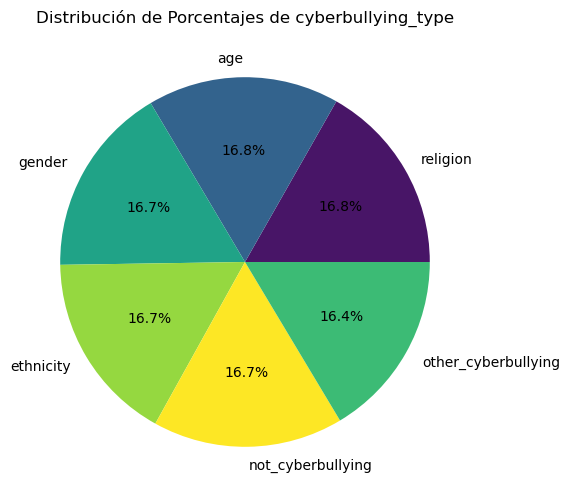

In [7]:
class_counts = df_raw['cyberbullying_type'].value_counts()
colors = ['#481567', '#33638D', '#20A387', '#95D840', '#FDE725', '#3CBB75']
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Distribución de Porcentajes de cyberbullying_type')
plt.show()

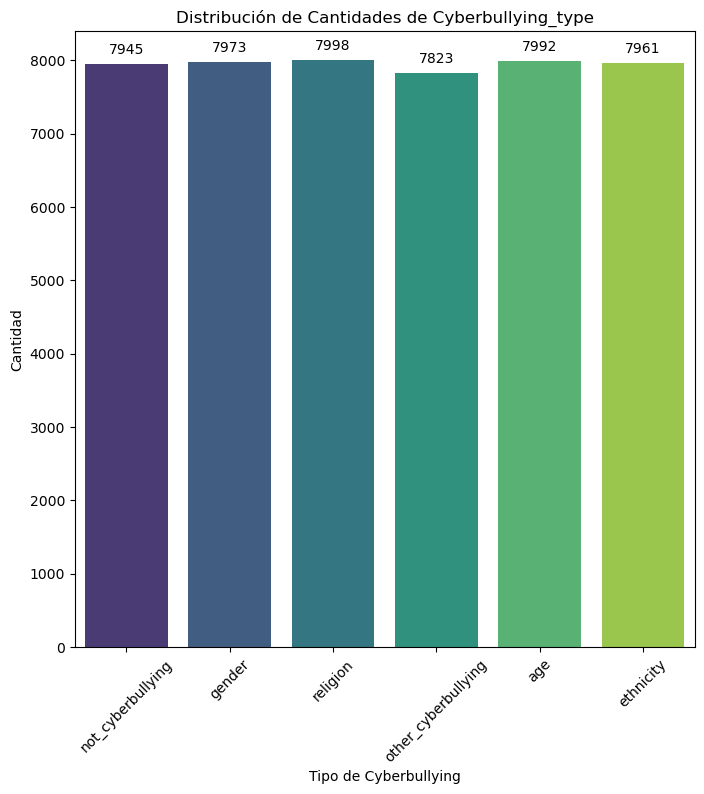

In [8]:
plt.figure(figsize=(8, 8))
ax = sns.countplot(data=df_raw, x='cyberbullying_type', palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Tipo de Cyberbullying')
plt.ylabel('Cantidad')
plt.title('Distribución de Cantidades de Cyberbullying_type')
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + 100,
        f'{int(p.get_height())}',
        ha='center',
        va='bottom'
    )

plt.show()

### Análisis de estadísticos

In [12]:
df_raw['text_length'] = df_raw['tweet_text'].apply(len)
df_raw

,tweet_text,cyberbullying_type,text_length
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,115
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,234
47688,Turner did not withhold his disappointment. Tu...,ethnicity,276
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,104
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,90


In [16]:
# Función para extraer estadísticas de un tweet
nlp = spacy.load("en_core_web_sm")

# Función para extraer estadísticas de un tweet
def analyze_tweet(text):
    doc = nlp(text)
    num_tokens = len(doc)
    num_words = len([token for token in doc if token.is_alpha])
    num_chars = len(text)
    num_stopwords = len([token for token in doc if token.is_stop])
    num_punctuations = len([token for token in doc if token.is_punct])
    num_nouns = len([token for token in doc if token.pos_ == "NOUN"])
    num_verbs = len([token for token in doc if token.pos_ == "VERB"])
    
    return {
        'num_tokens': num_tokens,
        'num_words': num_words,
        'num_chars': num_chars,
        'num_stopwords': num_stopwords,
        'num_punctuations': num_punctuations,
        'num_nouns': num_nouns,
        'num_verbs': num_verbs
    }

# Aplicar la función a cada tweet en el DataFrame
stats = df_raw['tweet_text'].apply(analyze_tweet)

# Convertir la lista de diccionarios en un DataFrame
stats_df = pd.DataFrame(list(stats))

# Añadir las estadísticas al DataFrame original
for column in stats_df.columns:
    df_raw[column] = stats_df[column]

# Añadir tokenización y lematización
df_raw['tokens'] = df_raw['tweet_text'].apply(lambda text: [token.text for token in nlp(text)])
df_raw['lemmas'] = df_raw['tweet_text'].apply(lambda text: [token.lemma_ for token in nlp(text)])

# Función para detectar outliers usando el IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Detectar outliers en las columnas numéricas
outliers_num_tokens = detect_outliers(df_raw, 'num_tokens')
outliers_num_words = detect_outliers(df_raw, 'num_words')
outliers_num_chars = detect_outliers(df_raw, 'num_chars')

print("Outliers en num_tokens:\n", outliers_num_tokens)
print("Outliers en num_words:\n", outliers_num_words)
print("Outliers en num_chars:\n", outliers_num_chars)

# Opcional: Tratar los outliers (por ejemplo, eliminarlos)
df_raw_cleaned = df_raw[~df_raw.index.isin(outliers_num_tokens.index)]
df_raw_cleaned = df_raw_cleaned[~df_raw_cleaned.index.isin(outliers_num_words.index)]
df_raw_cleaned = df_raw_cleaned[~df_raw_cleaned.index.isin(outliers_num_chars.index)]

# Mostrar el DataFrame resultante
print(df_raw_cleaned)

Outliers en num_tokens:
                                               tweet_text cyberbullying_type  \
1317   @EurekAlertAAAS: Researchers push to import to...  not_cyberbullying   
3030   He embellished the afternoon with moustachioed...  not_cyberbullying   
4846   @andrea_gcav: @viviaanajim recuerdas como noso...  not_cyberbullying   
8025   -TW- My aunt's boyfriend showed up to Thanksgi...             gender   
8182   Yeah, but he already had his brain damaged. He...             gender   
...                                                  ...                ...   
46637  Fuck my so called mama for giving birth to the...          ethnicity   
46764  hi queen! first of all im rlly happy to be moo...          ethnicity   
47037  @Purely_Ambition: Sooo mad. RT @TracePeterson ...          ethnicity   
47352  first impression: WEEB? your nickname in my he...          ethnicity   
47573  I know this white Latina that found out her gr...          ethnicity   

       text_length  num_to

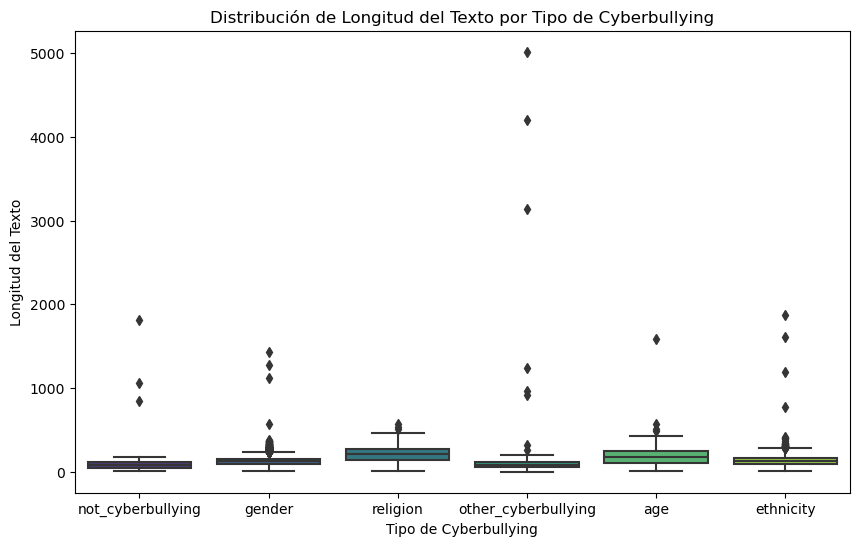

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_raw, x='cyberbullying_type', y='text_length' , palette='viridis')
plt.xlabel('Tipo de Cyberbullying')
plt.ylabel('Longitud del Texto')
plt.title('Distribución de Longitud del Texto por Tipo de Cyberbullying')
plt.show()

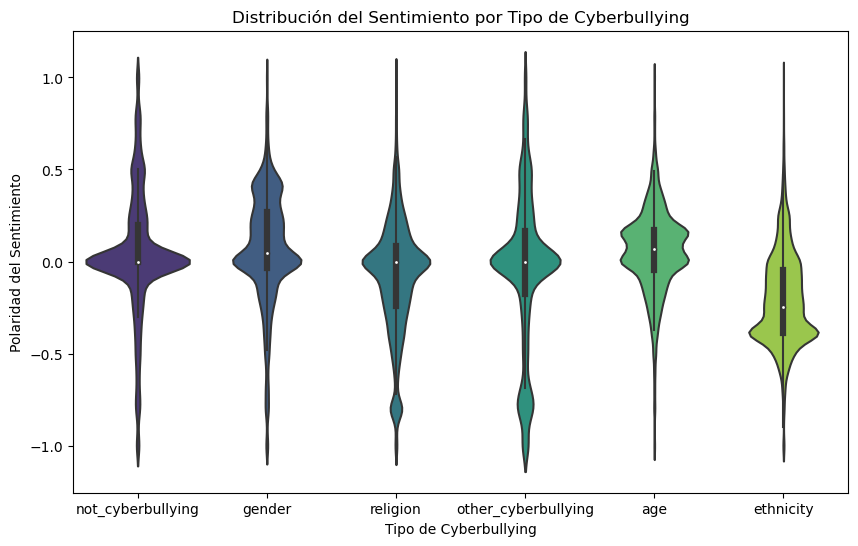

In [18]:
df_raw['sentiment'] = df_raw['tweet_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 6))
sns.violinplot(data=df_raw, x='cyberbullying_type', y='sentiment', palette='viridis')
plt.xlabel('Tipo de Cyberbullying')
plt.ylabel('Polaridad del Sentimiento')
plt.title('Distribución del Sentimiento por Tipo de Cyberbullying')
plt.show()

In [19]:
df_raw

,tweet_text,cyberbullying_type,text_length,num_tokens,num_words,num_chars,num_stopwords,num_punctuations,num_nouns,num_verbs,tokens,lemmas,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61,13,9,61,4,4,5,0,"[In, other, words, #, katandandre, ,, your, fo...","[in, other, word, #, katandandre, ,, your, foo...",-0.156250
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,115,25,13,115,3,11,6,0,"[Why, is, #, aussietv, so, white, ?, #, MKR, #...","[why, be, #, aussietv, so, white, ?, #, mkr, #...",0.000000
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60,11,8,60,3,2,3,1,"[@XochitlSuckkks, a, classy, whore, ?, Or, mor...","[@xochitlsuckkks, a, classy, whore, ?, or, mor...",0.200000
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103,22,16,103,9,3,5,0,"[@Jason_Gio, meh, ., :P, , thanks, for, the, ...","[@Jason_Gio, meh, ., :P, , thank, for, the, h...",0.150000
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103,22,17,103,9,3,3,1,"[@RudhoeEnglish, This, is, an, ISIS, account, ...","[@RudhoeEnglish, this, be, an, ISIS, account, ...",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,234,49,42,234,26,6,7,9,"[Black, ppl, are, n't, expected, to, do, anyth...","[black, ppl, be, not, expect, to, do, anything...",0.011905
47688,Turner did not withhold his disappointment. Tu...,ethnicity,276,53,45,276,20,8,12,6,"[Turner, did, not, withhold, his, disappointme...","[Turner, do, not, withhold, his, disappointmen...",-0.300000
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,104,26,19,104,7,6,3,4,"[I, swear, to, God, ., This, dumb, nigger, bit...","[I, swear, to, God, ., this, dumb, nigger, bit...",-0.387500
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,90,18,14,90,4,3,4,0,"[Yea, fuck, you, RT, @therealexel, :, IF, YOUR...","[yea, fuck, you, RT, @therealexel, :, if, YOUR...",-0.458333


### Diccionario de mapeo de tipos de bullying (clases) a números


In [20]:
cyberbullying_classes = {
    "not_cyberbullying": 0,
    "gender": 1,
    "religion": 2,
    "other_cyberbullying": 3,
    "age": 4,
    "ethnicity": 5
}

df_raw['cyberbullying_numeric_type'] = df_raw['cyberbullying_type'].map(cyberbullying_classes)
df_raw.head()

,tweet_text,cyberbullying_type,text_length,num_tokens,num_words,num_chars,num_stopwords,num_punctuations,num_nouns,num_verbs,tokens,lemmas,sentiment,cyberbullying_numeric_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61,13,9,61,4,4,5,0,"[In, other, words, #, katandandre, ,, your, fo...","[in, other, word, #, katandandre, ,, your, foo...",-0.15625,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,115,25,13,115,3,11,6,0,"[Why, is, #, aussietv, so, white, ?, #, MKR, #...","[why, be, #, aussietv, so, white, ?, #, mkr, #...",0.00000,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60,11,8,60,3,2,3,1,"[@XochitlSuckkks, a, classy, whore, ?, Or, mor...","[@xochitlsuckkks, a, classy, whore, ?, or, mor...",0.20000,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103,22,16,103,9,3,5,0,"[@Jason_Gio, meh, ., :P, , thanks, for, the, ...","[@Jason_Gio, meh, ., :P, , thank, for, the, h...",0.15000,0
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103,22,17,103,9,3,3,1,"[@RudhoeEnglish, This, is, an, ISIS, account, ...","[@RudhoeEnglish, this, be, an, ISIS, account, ...",0.00000,0


In [21]:
df_raw.tail()

,tweet_text,cyberbullying_type,text_length,num_tokens,num_words,num_chars,num_stopwords,num_punctuations,num_nouns,num_verbs,tokens,lemmas,sentiment,cyberbullying_numeric_type
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,234,49,42,234,26,6,7,9,"[Black, ppl, are, n't, expected, to, do, anyth...","[black, ppl, be, not, expect, to, do, anything...",0.011905,5
47688,Turner did not withhold his disappointment. Tu...,ethnicity,276,53,45,276,20,8,12,6,"[Turner, did, not, withhold, his, disappointme...","[Turner, do, not, withhold, his, disappointmen...",-0.300000,5
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,104,26,19,104,7,6,3,4,"[I, swear, to, God, ., This, dumb, nigger, bit...","[I, swear, to, God, ., this, dumb, nigger, bit...",-0.387500,5
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,90,18,14,90,4,3,4,0,"[Yea, fuck, you, RT, @therealexel, :, IF, YOUR...","[yea, fuck, you, RT, @therealexel, :, if, YOUR...",-0.458333,5
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity,76,17,14,76,1,2,2,2,"[Bro, ., U, got, ta, chill, RT, @CHILLShrammy,...","[bro, ., u, get, to, chill, RT, @chillshrammy,...",-0.058333,5


### Exploración de Relaciones

Hay que seguir investigando la naturaleza de la variable other_cyberbullying y entender si es posible utilizarla como regresora también, al igual que age, religion, ethnicity.

In [22]:
def preprocess_column(column):
    column = column.str.lower() # convertir los tweets a minuscula.
    return column

df_raw['tweet_text'] = preprocess_column(df_raw['tweet_text'])
df_raw.head()

,tweet_text,cyberbullying_type,text_length,num_tokens,num_words,num_chars,num_stopwords,num_punctuations,num_nouns,num_verbs,tokens,lemmas,sentiment,cyberbullying_numeric_type
0,"in other words #katandandre, your food was cra...",not_cyberbullying,61,13,9,61,4,4,5,0,"[In, other, words, #, katandandre, ,, your, fo...","[in, other, word, #, katandandre, ,, your, foo...",-0.15625,0
1,why is #aussietv so white? #mkr #theblock #ima...,not_cyberbullying,115,25,13,115,3,11,6,0,"[Why, is, #, aussietv, so, white, ?, #, MKR, #...","[why, be, #, aussietv, so, white, ?, #, mkr, #...",0.00000,0
2,@xochitlsuckkks a classy whore? or more red ve...,not_cyberbullying,60,11,8,60,3,2,3,1,"[@XochitlSuckkks, a, classy, whore, ?, Or, mor...","[@xochitlsuckkks, a, classy, whore, ?, or, mor...",0.20000,0
3,"@jason_gio meh. :p thanks for the heads up, b...",not_cyberbullying,103,22,16,103,9,3,5,0,"[@Jason_Gio, meh, ., :P, , thanks, for, the, ...","[@Jason_Gio, meh, ., :P, , thank, for, the, h...",0.15000,0
4,@rudhoeenglish this is an isis account pretend...,not_cyberbullying,103,22,17,103,9,3,3,1,"[@RudhoeEnglish, This, is, an, ISIS, account, ...","[@RudhoeEnglish, this, be, an, ISIS, account, ...",0.00000,0


In [23]:
nltk.download('punkt')
nltk.download('stopwords')

# Define la función clean_tweet
def clean_tweet(tweet:str) -> str:
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE) # Remove urls
    tweet = re.sub(r'@[A-Za-z0-9]+','', tweet) # Remove @mentions
    tweet = re.sub(r'\#[A-Za-z0-9]+','', tweet) # Remove hashtags
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet) # Remove special characters and punctuation
    tweet = tweet.lower() # Convert to lowercase

    tokens = word_tokenize(tweet) # Tokenize

    stop_words = set(stopwords.words('english')) # Remove stopwords
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    clean_tweet = ' '.join(filtered_tokens) # Join tokens back into string

    return clean_tweet


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/noeliaqualindi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noeliaqualindi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Se aplica la función clean_tweet a la columna 'tweet_text' y limpiamos los tweets de urls y caracteres especiales


In [24]:
df_raw['clean_tweet'] = df_raw['tweet_text'].apply(clean_tweet)

# mostramos los primeros registros del dataframe limpio
df_raw.head()

,tweet_text,cyberbullying_type,text_length,num_tokens,num_words,num_chars,num_stopwords,num_punctuations,num_nouns,num_verbs,tokens,lemmas,sentiment,cyberbullying_numeric_type,clean_tweet
0,"in other words #katandandre, your food was cra...",not_cyberbullying,61,13,9,61,4,4,5,0,"[In, other, words, #, katandandre, ,, your, fo...","[in, other, word, #, katandandre, ,, your, foo...",-0.15625,0,words food crapilicious
1,why is #aussietv so white? #mkr #theblock #ima...,not_cyberbullying,115,25,13,115,3,11,6,0,"[Why, is, #, aussietv, so, white, ?, #, MKR, #...","[why, be, #, aussietv, so, white, ?, #, mkr, #...",0.00000,0,white
2,@xochitlsuckkks a classy whore? or more red ve...,not_cyberbullying,60,11,8,60,3,2,3,1,"[@XochitlSuckkks, a, classy, whore, ?, Or, mor...","[@xochitlsuckkks, a, classy, whore, ?, or, mor...",0.20000,0,classy whore red velvet cupcakes
3,"@jason_gio meh. :p thanks for the heads up, b...",not_cyberbullying,103,22,16,103,9,3,5,0,"[@Jason_Gio, meh, ., :P, , thanks, for, the, ...","[@Jason_Gio, meh, ., :P, , thank, for, the, h...",0.15000,0,gio meh p thanks heads concerned another angry...
4,@rudhoeenglish this is an isis account pretend...,not_cyberbullying,103,22,17,103,9,3,3,1,"[@RudhoeEnglish, This, is, an, ISIS, account, ...","[@RudhoeEnglish, this, be, an, ISIS, account, ...",0.00000,0,isis account pretending kurdish account like i...


### Contabilización de palabras

In [25]:
def count_words(df: pd.DataFrame, cyberbullying_type : str = None):
    if cyberbullying_type is None:
        df_count = df
    else:
        df_count = df[df['cyberbullying_type'] == cyberbullying_type]

    text = ' '.join(df_count['clean_tweet'])
    words = text.split()
    word_counts = Counter(words)

    return word_counts

In [26]:
count_words(df_raw)

Counter({'school': 8711,
         'like': 5867,
         'fuck': 5800,
         'dumb': 5330,
         'high': 5096,
         'people': 4812,
         'bullied': 4664,
         'im': 4497,
         'dont': 4407,
         'nigger': 4301,
         'rt': 4292,
         'rape': 4223,
         'u': 4112,
         'gay': 3971,
         'bully': 3586,
         'jokes': 3462,
         'one': 3404,
         'get': 2846,
         'girls': 2833,
         'ass': 2797,
         'girl': 2710,
         'black': 2695,
         'amp': 2608,
         'muslims': 2403,
         'know': 2342,
         'muslim': 2324,
         'white': 2187,
         'think': 2130,
         'would': 2055,
         'joke': 2031,
         'bitch': 2025,
         'idiot': 1983,
         'got': 1878,
         'right': 1836,
         'say': 1744,
         'fucking': 1677,
         'call': 1676,
         'even': 1657,
         'bullies': 1647,
         'go': 1639,
         'women': 1623,
         'cant': 1618,
         'make': 16

In [27]:
def words_bar_charts(dataframe: pd.DataFrame, cyberbullying_classes: dict):
    num_classes = len(cyberbullying_classes)


    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12), sharey=True)

    axes = axes.ravel()

    viridis_colors = plt.cm.viridis(np.linspace(0, 1, num_classes))

    for i, (ax, (cyberbullying_type, value)) in enumerate(zip(axes, cyberbullying_classes.items())):
        df_filter = dataframe[dataframe['cyberbullying_numeric_type'] == value]

        text = ' '.join(df_filter['clean_tweet'].to_list())
        words = text.split()
        word_counts = Counter(words)
        top_words = word_counts.most_common(20)
        words, counts = zip(*top_words)

        ax.bar(words, counts, color=viridis_colors[i])
        ax.set_title(f'Top 20 palabras en tweets de tipo "{cyberbullying_type}"')
        ax.set_xlabel('Palabra')
        ax.set_ylabel('Cantidad')
        ax.tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


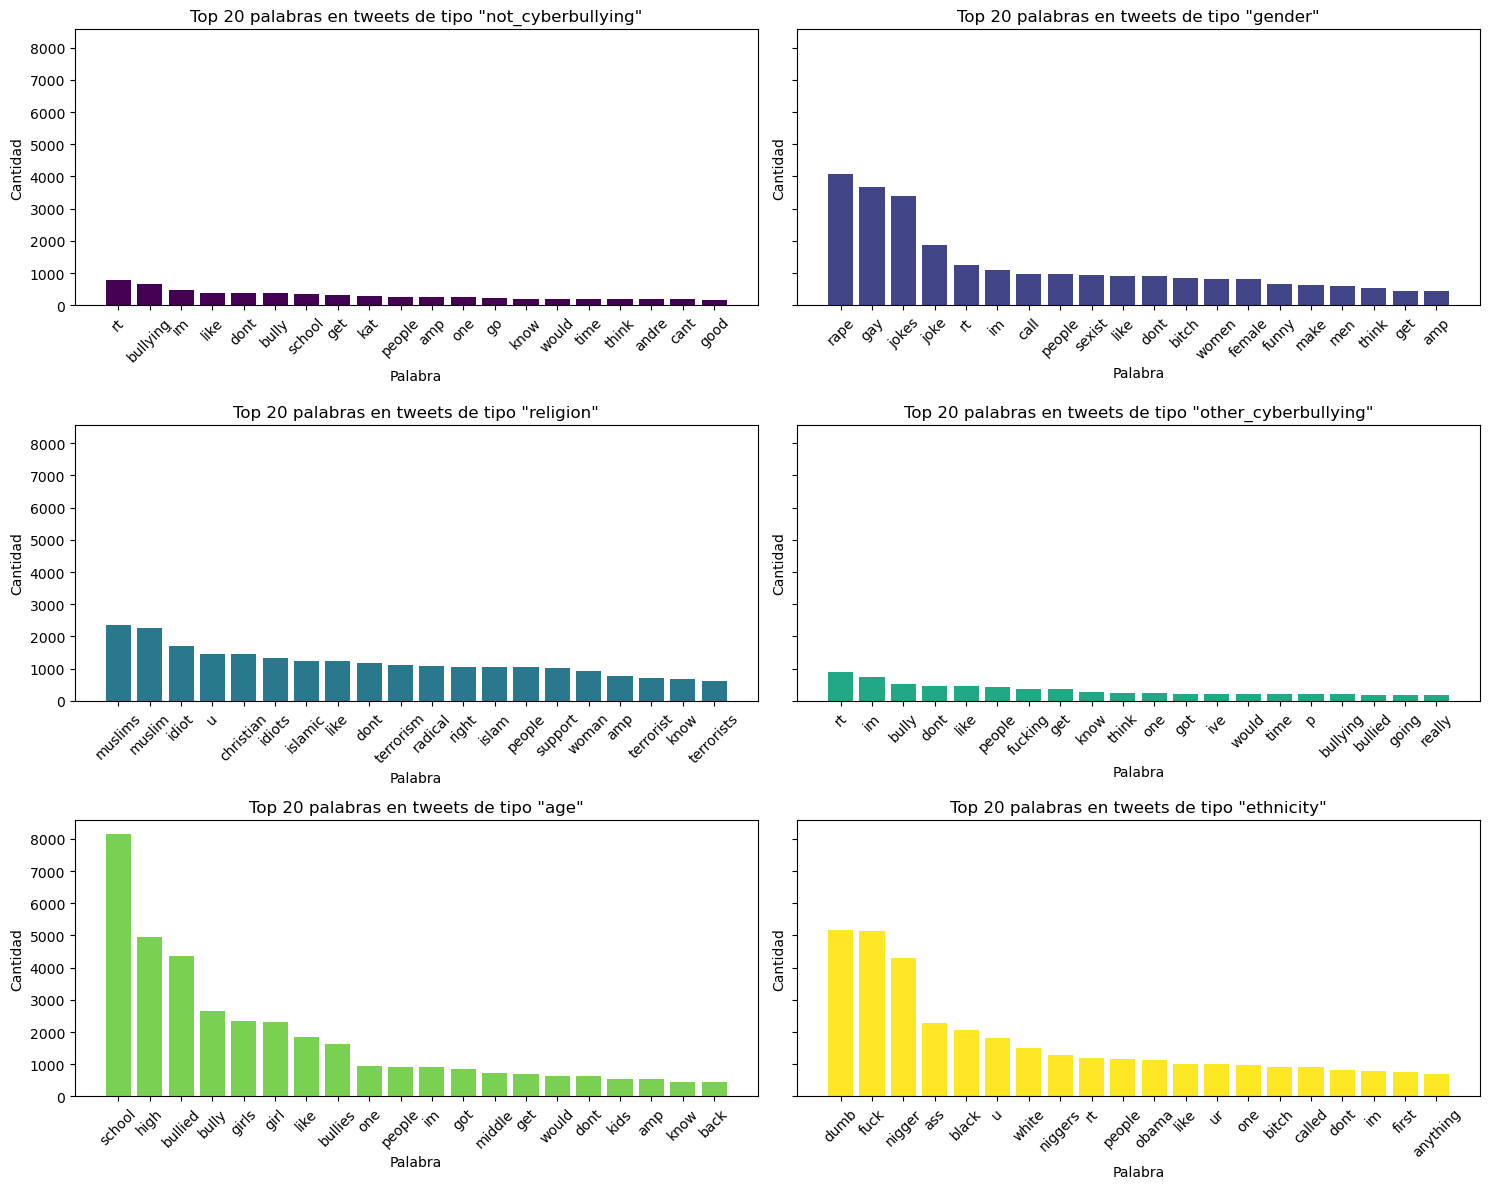

In [28]:
words_bar_charts(df_raw, cyberbullying_classes)

In [31]:
def wordcloud_subplots(dataframe: pd.DataFrame, cyberbullying_classes: dict):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

    axes = axes.ravel()

    for ax, (cyberbullying_type, value) in zip(axes, cyberbullying_classes.items()):
        df_filter = dataframe[dataframe['cyberbullying_numeric_type'] == value]

        text = ' '.join(df_filter['clean_tweet'].to_list())

        wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Nube de palabras para "{cyberbullying_type}"')
        ax.axis('off')

    for i in range(len(cyberbullying_classes), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

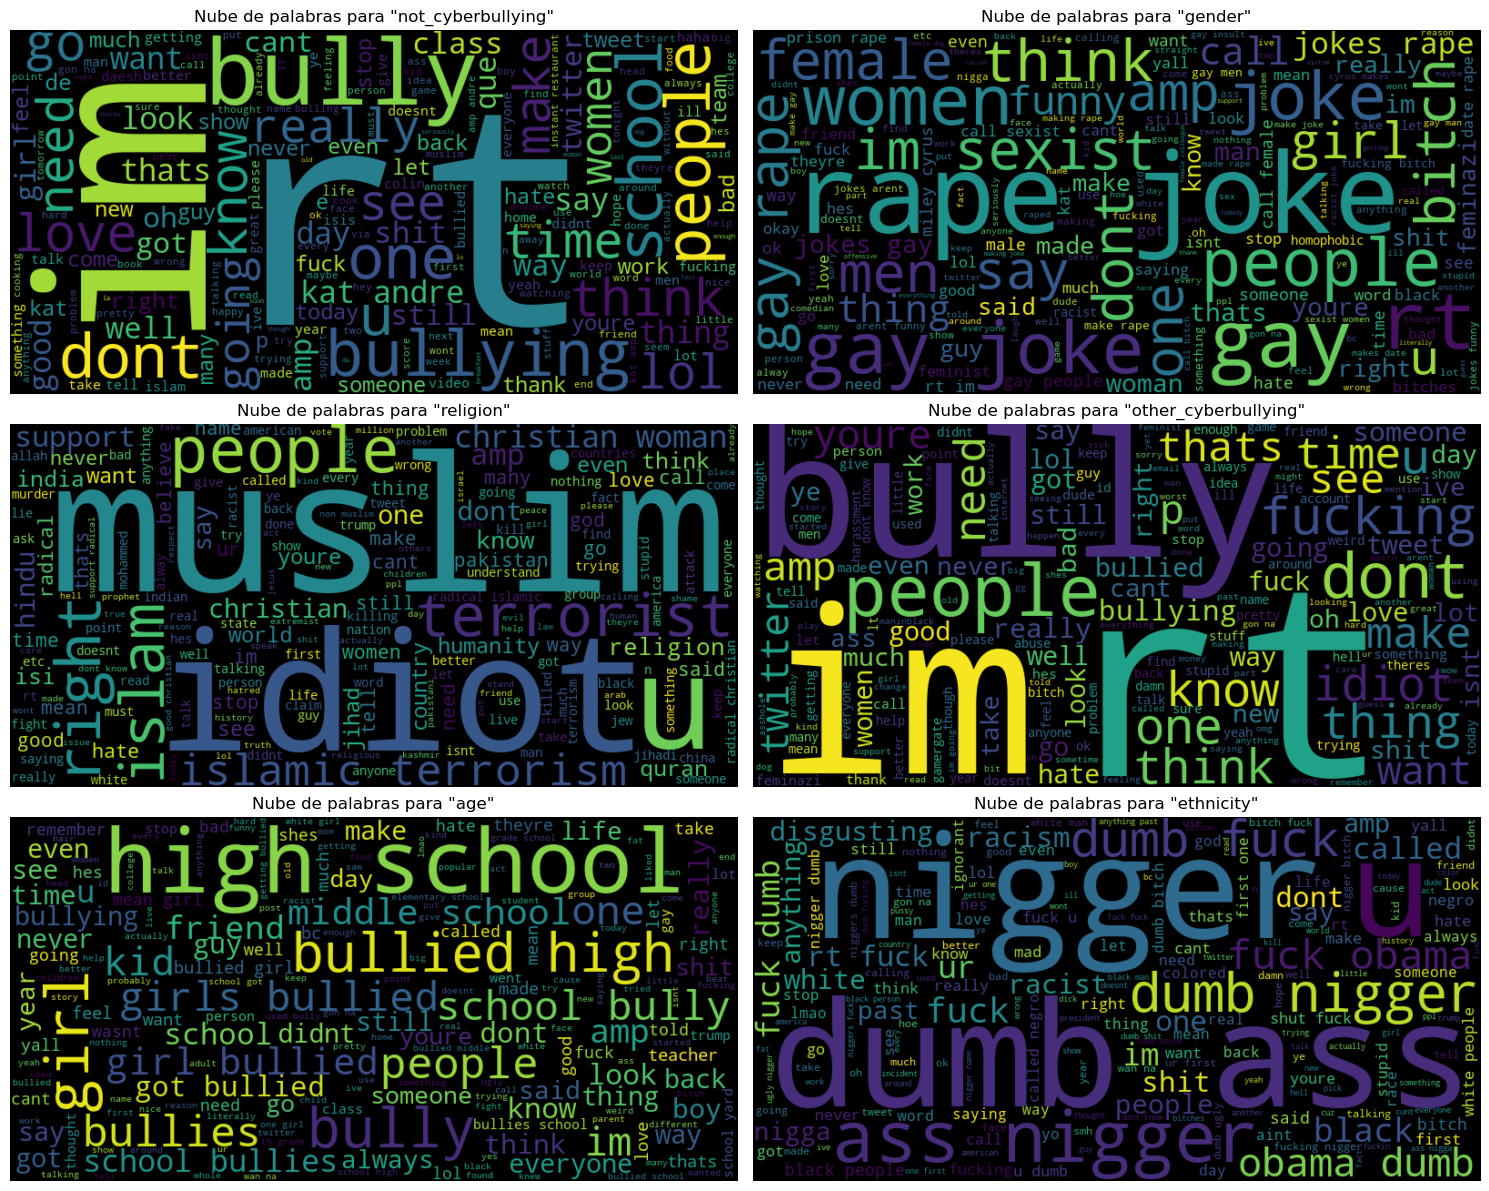

In [30]:
wordcloud_subplots(df_raw, cyberbullying_classes)

## Análisis y tratamiento de Outliers

In [32]:
# Función para extraer estadísticas de un tweet
def analyze_tweet(text):
    doc = nlp(text)
    num_tokens = len(doc)
    num_words = len([token for token in doc if token.is_alpha])
    num_chars = len(text)
    num_stopwords = len([token for token in doc if token.is_stop])
    num_punctuations = len([token for token in doc if token.is_punct])
    num_nouns = len([token for token in doc if token.pos_ == "NOUN"])
    num_verbs = len([token for token in doc if token.pos_ == "VERB"])
    
    return {
        'num_tokens': num_tokens,
        'num_words': num_words,
        'num_chars': num_chars,
        'num_stopwords': num_stopwords,
        'num_punctuations': num_punctuations,
        'num_nouns': num_nouns,
        'num_verbs': num_verbs
    }

# Aplicar la función a cada tweet en el DataFrame
stats = df_raw['clean_tweet'].apply(analyze_tweet)

# Convertir la lista de diccionarios en un DataFrame
stats_df = pd.DataFrame(list(stats))

# Añadir las estadísticas al DataFrame original
for column in stats_df.columns:
    df_raw[column] = stats_df[column]

# Añadir tokenización y lematización
df_raw['tokens'] = df_raw['clean_tweet'].apply(lambda text: [token.text for token in nlp(text)])
df_raw['lemmas'] = df_raw['clean_tweet'].apply(lambda text: [token.lemma_ for token in nlp(text)])

# Función para detectar outliers usando el IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detectar outliers en las columnas numéricas
outliers_num_tokens, lb_tokens, ub_tokens = detect_outliers(df_raw, 'num_tokens')
outliers_num_words, lb_words, ub_words = detect_outliers(df_raw, 'num_words')
outliers_num_chars, lb_chars, ub_chars = detect_outliers(df_raw, 'num_chars')

# Mostrar tablas de outliers
print("Outliers en num_tokens:\n", outliers_num_tokens)
print("Outliers en num_words:\n", outliers_num_words)
print("Outliers en num_chars:\n", outliers_num_chars)


Outliers en num_tokens:
                                               tweet_text cyberbullying_type  \
1317   @eurekalertaaas: researchers push to import to...  not_cyberbullying   
3030   he embellished the afternoon with moustachioed...  not_cyberbullying   
4846   @andrea_gcav: @viviaanajim recuerdas como noso...  not_cyberbullying   
8062   is just so so creepy. if i joke about way less...             gender   
8111   y’all: “haha drunk pussy the best pussy” “when...             gender   
...                                                  ...                ...   
46169  @wizcrdwheezes hihihi ily from the bottom of m...          ethnicity   
46764  hi queen! first of all im rlly happy to be moo...          ethnicity   
47037  @purely_ambition: sooo mad. rt @tracepeterson ...          ethnicity   
47195  keeth i stg. he literally struggles to stream ...          ethnicity   
47619  vice was abt interviews, which explained y tra...          ethnicity   

       text_length  num_to

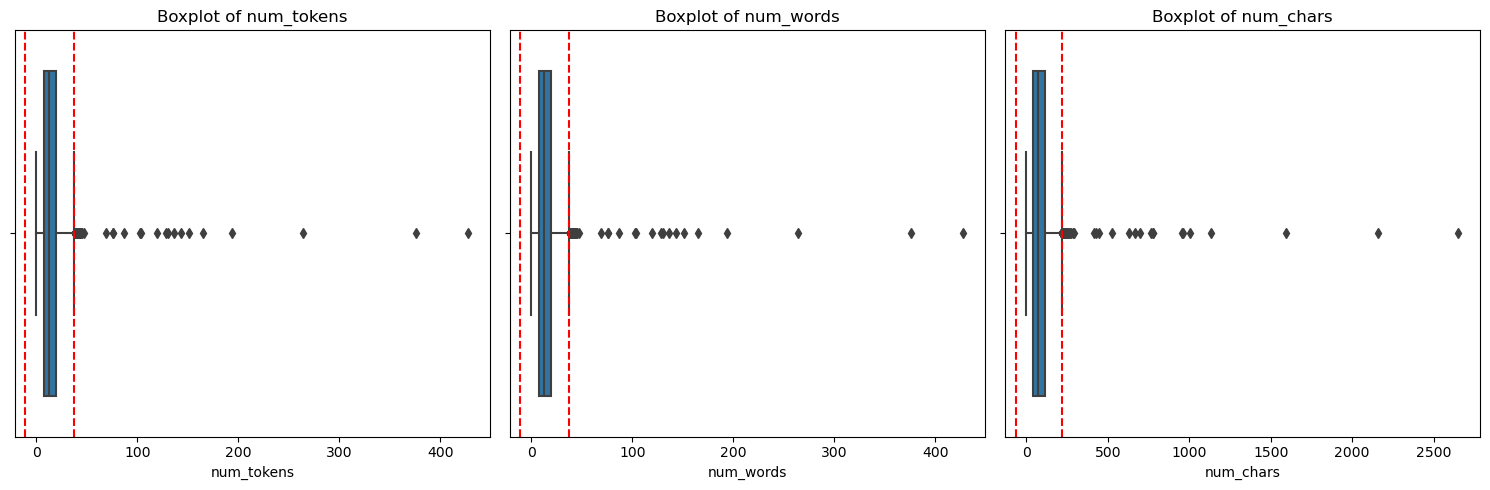

In [33]:
# Visualización de outliers usando gráficos de caja
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x=df_raw['num_tokens'])
plt.axvline(lb_tokens, color='r', linestyle='--')
plt.axvline(ub_tokens, color='r', linestyle='--')
plt.title('Boxplot of num_tokens')

plt.subplot(1, 3, 2)
sns.boxplot(x=df_raw['num_words'])
plt.axvline(lb_words, color='r', linestyle='--')
plt.axvline(ub_words, color='r', linestyle='--')
plt.title('Boxplot of num_words')

plt.subplot(1, 3, 3)
sns.boxplot(x=df_raw['num_chars'])
plt.axvline(lb_chars, color='r', linestyle='--')
plt.axvline(ub_chars, color='r', linestyle='--')
plt.title('Boxplot of num_chars')

plt.tight_layout()
plt.show()

In [49]:
df_raw.describe()

,text_length,num_tokens,num_words,num_chars,num_stopwords,num_punctuations,num_nouns,num_verbs,sentiment,cyberbullying_numeric_type,word_count
count,47692.000000,47692.000000,47692.000000,47692.000000,47692.000000,47692.0,47692.000000,47692.000000,47692.000000,47692.000000,47692.000000
mean,136.253229,13.502726,13.502726,82.618846,1.811897,0.0,4.518934,2.878177,-0.027226,2.499602,23.704835
std,85.226899,8.906400,8.906400,56.677589,1.979130,0.0,3.376061,2.319892,0.324770,1.708993,15.434881
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-1.000000,0.000000,1.000000
25%,78.000000,7.000000,7.000000,43.000000,0.000000,0.0,2.000000,1.000000,-0.192857,1.000000,13.000000
50%,124.000000,12.000000,12.000000,70.000000,1.000000,0.0,4.000000,2.000000,0.000000,2.000000,20.000000
75%,180.000000,19.000000,19.000000,114.000000,3.000000,0.0,6.000000,4.000000,0.158688,4.000000,32.000000
max,5018.000000,428.000000,428.000000,2652.000000,71.000000,0.0,142.000000,91.000000,1.000000,5.000000,790.000000


### Análisis de valores nulos

In [50]:
num_null_tweets = df_raw['tweet_text'].isnull().sum()

print("Cantidad de tweets con valores nulos en 'tweet_text':", num_null_tweets)

Cantidad de tweets con valores nulos en 'tweet_text': 0


#### Cantidad de tweets de 1 sola palabra

In [51]:
df_raw['word_count'] = df_raw['tweet_text'].apply(lambda x: len(str(x).split()))

# Filtrar los tweets que tienen solo una palabra
single_word_tweets = df_raw[df_raw['word_count'] == 1]

# Mostrar la cantidad de estos outliers
num_single_word_tweets = single_word_tweets.shape[0]

pd.set_option('display.max_rows', None)  # Mostrar todas las filas
print("Cantidad de tweets de una sola palabra (outliers semánticos a analizar):", num_single_word_tweets)
print("Tweets de una sola palabra:\n", single_word_tweets[['clean_tweet']])

Cantidad de tweets de una sola palabra (outliers semánticos a analizar): 204
Tweets de una sola palabra:
                                             clean_tweet
173                                                    
307                                                    
314                                           preseason
334                                                 ffs
795                                                    
853                                               rtvid
921                                                    
1136                                                   
1369                                                   
1385                                           hahahaha
1409                                                   
1422                                                   
1513                                                   
1702                                              laura
1839                                                  

## Limpieza de datos

In [52]:
# Eliminar filas donde la columna cyberbullying_type sea 'other_cyberbullying'
df_filtered = df_raw[df_raw['cyberbullying_type'] != 'other_cyberbullying']

# Agregar una columna para el conteo de palabras en cada tweet
df_filtered['word_count'] = df_filtered['tweet_text'].apply(lambda x: len(str(x).split()))

# Filtrar los tweets que tienen solo una palabra
single_word_tweets = df_filtered[df_filtered['word_count'] == 1]

# Mostrar la cantidad de estos outliers
num_single_word_tweets = single_word_tweets.shape[0]

# Mostrar los tweets de una sola palabra
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
print("Cantidad de tweets de una sola palabra (outliers semánticos a analizar):", num_single_word_tweets)
print("Tweets de una sola palabra:\n", single_word_tweets[['tweet_text']])

# Eliminar los tweets de una sola palabra del DataFrame
df_cleaned = df_filtered[df_filtered['word_count'] > 1]

# Resetear el índice del DataFrame limpio si es necesario
df_cleaned = df_cleaned.reset_index(drop=True)

# Imprimir el DataFrame resultante para revisar la limpieza
print("DataFrame limpio:\n", df_cleaned.head())

Cantidad de tweets de una sola palabra (outliers semánticos a analizar): 80
Tweets de una sola palabra:
                                               tweet_text
173                                        #simpleasthat
307                                                   :d
314                                            preseason
334                                                  ffs
795                               http://t.co/o6tduczw5z
853                      rt:@.vid.http://t.co/vdl5vwxkrj
921                                                 #fat
1136                              http://t.co/vsobneh81v
1369                                            #mrburns
1385                                            hahahaha
1409                                     @takeastand2day
1422                              http://t.co/f2nxfz8vtz
1513                          #ultimatecollegeblackparty
1702                                              ~laura
1839                                    

/var/folders/ml/g_sxsst10mj890krz6gpp0980000gn/T/ipykernel_22471/4240227045.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['word_count'] = df_filtered['tweet_text'].apply(lambda x: len(str(x).split()))


In [68]:
# Diccionario de clases ajustado
cyberbullying_classes = {
    "not_cyberbullying": 0,
    "gender": 1,
    "religion": 2,
    "age": 3,
    "ethnicity": 4
}

df_cleaned['cyberbullying_numeric_type'] = df_cleaned['cyberbullying_type'].apply(lambda x: cyberbullying_classes[x])


### Tokenización y Lemmatización

In [69]:
nlp = spacy.load("en_core_web_sm")
df_cleaned['tokens'] = df_cleaned['clean_tweet'].apply(lambda text: [token.text for token in nlp(text)])
df_cleaned.head()

,tweet_text,cyberbullying_type,text_length,num_tokens,num_words,num_chars,num_stopwords,num_punctuations,num_nouns,num_verbs,tokens,lemmas,sentiment,cyberbullying_numeric_type,clean_tweet,word_count
0,"in other words #katandandre, your food was cra...",not_cyberbullying,61,3,3,23,0,0,2,0,"[words, food, crapilicious]","[word, food, crapilicious]",-0.15625,0,words food crapilicious,9
1,why is #aussietv so white? #mkr #theblock #ima...,not_cyberbullying,115,1,1,5,0,0,0,0,[white],[white],0.00000,0,white,14
2,@xochitlsuckkks a classy whore? or more red ve...,not_cyberbullying,60,5,5,32,0,0,3,0,"[classy, whore, red, velvet, cupcakes]","[classy, whore, red, velvet, cupcake]",0.20000,0,classy whore red velvet cupcakes,9
3,"@jason_gio meh. :p thanks for the heads up, b...",not_cyberbullying,103,10,10,59,1,0,5,1,"[gio, meh, p, thanks, heads, concerned, anothe...","[gio, meh, p, thank, head, concern, another, a...",0.15000,0,gio meh p thanks heads concerned another angry...,18
4,@rudhoeenglish this is an isis account pretend...,not_cyberbullying,103,8,8,55,0,0,3,2,"[isis, account, pretending, kurdish, account, ...","[isis, account, pretend, kurdish, account, lik...",0.00000,0,isis account pretending kurdish account like i...,18


In [43]:
def lemmatize_text(text):
  doc = nlp(text)
  lemmas = [token.lemma_ for token in doc]
  return lemmas

In [48]:
df_cleaned['lemas'] = df_cleaned['clean_tweet'].apply(lemmatize_text)
df_cleaned.head()

,tweet_text,cyberbullying_type,text_length,num_tokens,num_words,num_chars,num_stopwords,num_punctuations,num_nouns,num_verbs,tokens,lemmas,sentiment,cyberbullying_numeric_type,clean_tweet,word_count,lemas
0,"in other words #katandandre, your food was cra...",not_cyberbullying,61,3,3,23,0,0,2,0,"[words, food, crapilicious]","[word, food, crapilicious]",-0.15625,0,words food crapilicious,9,"[word, food, crapilicious]"
1,why is #aussietv so white? #mkr #theblock #ima...,not_cyberbullying,115,1,1,5,0,0,0,0,[white],[white],0.00000,0,white,14,[white]
2,@xochitlsuckkks a classy whore? or more red ve...,not_cyberbullying,60,5,5,32,0,0,3,0,"[classy, whore, red, velvet, cupcakes]","[classy, whore, red, velvet, cupcake]",0.20000,0,classy whore red velvet cupcakes,9,"[classy, whore, red, velvet, cupcake]"
3,"@jason_gio meh. :p thanks for the heads up, b...",not_cyberbullying,103,10,10,59,1,0,5,1,"[gio, meh, p, thanks, heads, concerned, anothe...","[gio, meh, p, thank, head, concern, another, a...",0.15000,0,gio meh p thanks heads concerned another angry...,18,"[gio, meh, p, thank, head, concern, another, a..."
4,@rudhoeenglish this is an isis account pretend...,not_cyberbullying,103,8,8,55,0,0,3,2,"[isis, account, pretending, kurdish, account, ...","[isis, account, pretend, kurdish, account, lik...",0.00000,0,isis account pretending kurdish account like i...,18,"[isis, account, pretend, kurdish, account, lik..."


### Búsqueda de mejores hiperparámetros 

In [81]:
# Dividir los datos en características y etiquetas
X = df_cleaned['clean_tweet']
y = df_cleaned['cyberbullying_numeric_type']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configurar el vectorizador TF-IDF
tfidf = TfidfVectorizer()

In [64]:
# Modelos a probar
models = {
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNeighbors': KNeighborsClassifier()
}

# Parámetros de búsqueda
params = {
    'SVM': {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']},
    'RandomForest': {'clf__n_estimators': [100, 200], 'clf__max_depth': [10, 20]},
    'LogisticRegression': {'clf__C': [0.1, 1, 10]},
    'KNeighbors': {'clf__n_neighbors': [3, 5, 7]}
}

# Pipeline para TF-IDF + Modelo
def create_pipeline(model):
    return Pipeline([
        ('tfidf', tfidf),
        ('clf', model)
    ])

# Diccionario para almacenar los mejores modelos
best_models = {}

# Búsqueda de hiperparámetros
for model_name in models:
    pipeline = create_pipeline(models[model_name])
    grid_search = GridSearchCV(pipeline, params[model_name], cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .......................clf__C=1, clf__kernel=linear; total time= 1.1min
[CV] END .......................clf__C=1, clf__kernel=linear; total time= 1.2min
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time= 1.9min
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time= 1.9min
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time= 1.9min
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time= 1.9min
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time= 1.9min
[CV] END .......................clf__C=1, clf__kernel=linear; total time= 1.1min
[CV] END .......................clf__C=1, clf__kernel=linear; total time= 1.1min
[CV] END .......................clf__C=1, clf__kernel=linear; total time= 1.2min
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time= 3.2min
[CV] END ........................clf__C=0.1, clf_

### Entrenamiento de modelos con mejores hiperparámetros

In [82]:
# Configurar el vectorizador TF-IDF
tfidf = TfidfVectorizer()

# Parámetros óptimos obtenidos
best_params = {
    'SVM': {'C': 1, 'kernel': 'linear'},
    'RandomForest': {'max_depth': 20, 'n_estimators': 200},
    'LogisticRegression': {'C': 10},
    'KNeighbors': {'n_neighbors': 7}
}

# Creación y entrenamiento de los modelos
models = {
    'SVM': SVC(C=best_params['SVM']['C'], kernel=best_params['SVM']['kernel'], probability=True),
    'RandomForest': RandomForestClassifier(max_depth=best_params['RandomForest']['max_depth'], n_estimators=best_params['RandomForest']['n_estimators']),
    'LogisticRegression': LogisticRegression(C=best_params['LogisticRegression']['C'], max_iter=1000),
    'KNeighbors': KNeighborsClassifier(n_neighbors=best_params['KNeighbors']['n_neighbors'])
}


## SVM

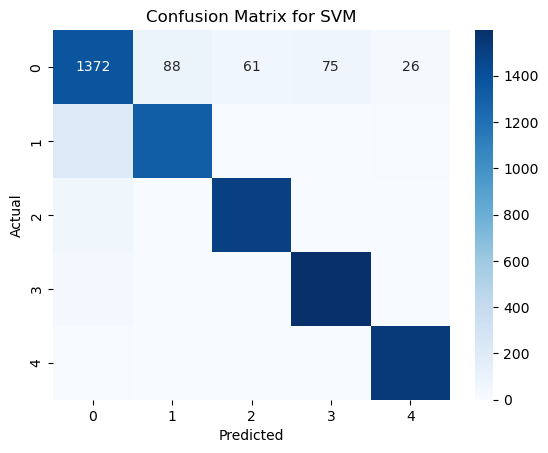

Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82      1622
           1       0.93      0.84      0.88      1555
           2       0.95      0.96      0.96      1571
           3       0.95      0.97      0.96      1645
           4       0.97      0.98      0.98      1565

    accuracy                           0.92      7958
   macro avg       0.92      0.92      0.92      7958
weighted avg       0.92      0.92      0.92      7958



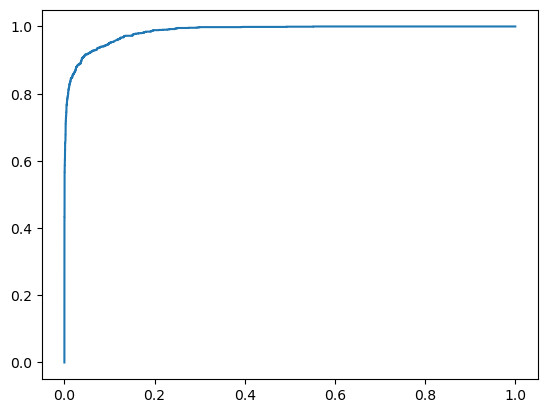

In [83]:
# Crear pipeline para SVM
svm_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', SVC(C=best_params['SVM']['C'], kernel=best_params['SVM']['kernel'], probability=True))
])

# Entrenar el modelo SVM
svm_pipeline.fit(X_train, y_train)

# Hacer predicciones
y_pred_svm = svm_pipeline.predict(X_test)

# Matriz de confusión
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Reporte de clasificación
print("Classification Report for SVM:\n", classification_report(y_test, y_pred_svm))

# Curva ROC y AUC
y_proba_svm = svm_pipeline.predict_proba(X_test)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm[:, 1], pos_label=svm_pipeline.classes_[1])
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.2f})")

## Random Forest

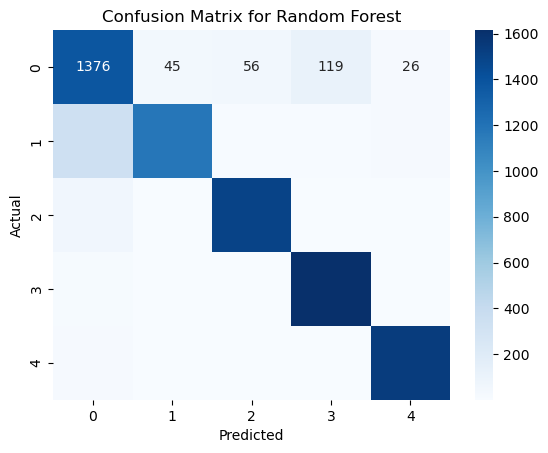

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80      1622
           1       0.95      0.75      0.84      1555
           2       0.96      0.95      0.95      1571
           3       0.92      0.98      0.95      1645
           4       0.97      0.98      0.97      1565

    accuracy                           0.90      7958
   macro avg       0.91      0.90      0.90      7958
weighted avg       0.91      0.90      0.90      7958



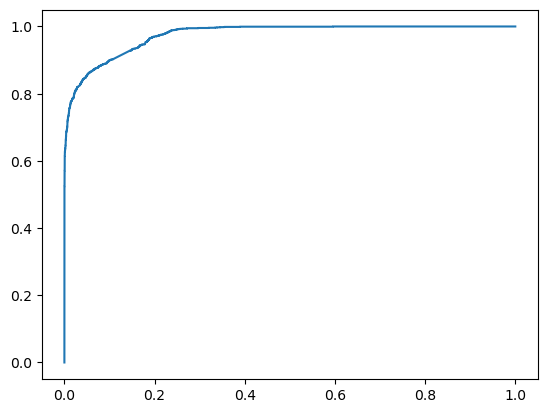

In [84]:
# Crear pipeline para Random Forest
rf_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', RandomForestClassifier(max_depth=best_params['RandomForest']['max_depth'], n_estimators=best_params['RandomForest']['n_estimators']))
])

# Entrenar el modelo Random Forest
rf_pipeline.fit(X_train, y_train)

# Hacer predicciones
y_pred_rf = rf_pipeline.predict(X_test)

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Reporte de clasificación
print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))

# Curva ROC y AUC
y_proba_rf = rf_pipeline.predict_proba(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf[:, 1], pos_label=rf_pipeline.classes_[1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")


## Regresión Logística

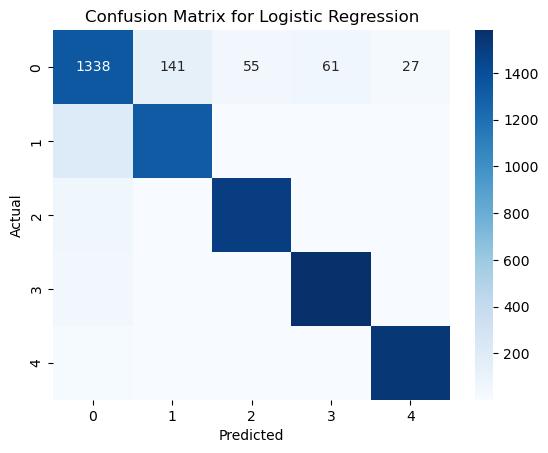

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      1622
           1       0.89      0.85      0.87      1555
           2       0.96      0.95      0.95      1571
           3       0.96      0.96      0.96      1645
           4       0.97      0.98      0.98      1565

    accuracy                           0.91      7958
   macro avg       0.91      0.91      0.91      7958
weighted avg       0.91      0.91      0.91      7958



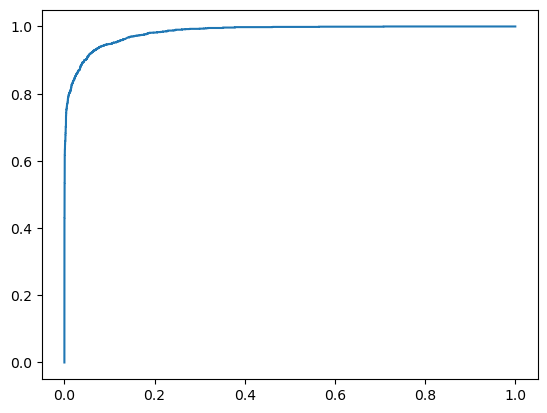

In [85]:
# Crear pipeline para Regresión Logística
lr_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', LogisticRegression(C=best_params['LogisticRegression']['C'], max_iter=1000))
])

# Entrenar el modelo Regresión Logística
lr_pipeline.fit(X_train, y_train)

# Hacer predicciones
y_pred_lr = lr_pipeline.predict(X_test)

# Matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Reporte de clasificación
print("Classification Report for Logistic Regression:\n", classification_report(y_test, y_pred_lr))

# Curva ROC y AUC
y_proba_lr = lr_pipeline.predict_proba(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr[:, 1], pos_label=lr_pipeline.classes_[1])
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})")


## K-Neighbors

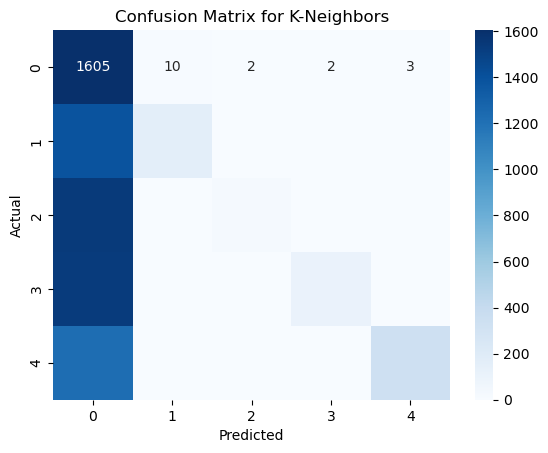

Classification Report for K-Neighbors:
               precision    recall  f1-score   support

           0       0.22      0.99      0.36      1622
           1       0.92      0.10      0.19      1555
           2       0.94      0.02      0.04      1571
           3       0.97      0.07      0.13      1645
           4       0.98      0.21      0.35      1565

    accuracy                           0.28      7958
   macro avg       0.81      0.28      0.21      7958
weighted avg       0.80      0.28      0.21      7958



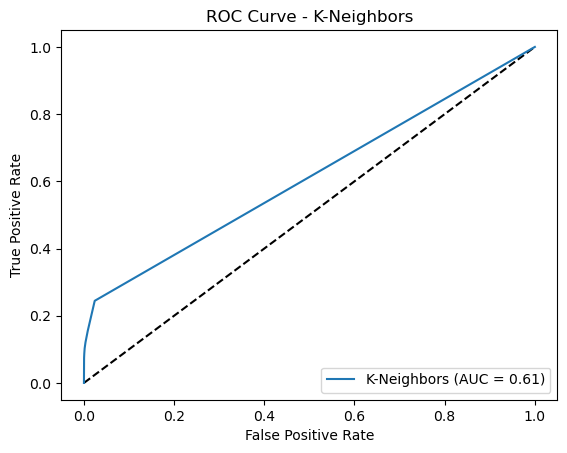

In [88]:
# Crear pipeline para K-Neighbors
knn_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', KNeighborsClassifier(n_neighbors=best_params['KNeighbors']['n_neighbors']))
])

# Entrenar el modelo K-Neighbors
knn_pipeline.fit(X_train, y_train)

# Hacer predicciones
y_pred_knn = knn_pipeline.predict(X_test)

# Matriz de confusión
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for K-Neighbors")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Reporte de clasificación
print("Classification Report for K-Neighbors:\n", classification_report(y_test, y_pred_knn))

# Curva ROC y AUC
y_proba_knn = knn_pipeline.predict_proba(X_test)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn[:, 1], pos_label=knn_pipeline.classes_[1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Graficar la curva ROC
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_knn, tpr_knn, label=f"K-Neighbors (AUC = {roc_auc_knn:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - K-Neighbors')
plt.legend(loc='lower right')
plt.show()

### Comparación de curvas ROC de cada modelo

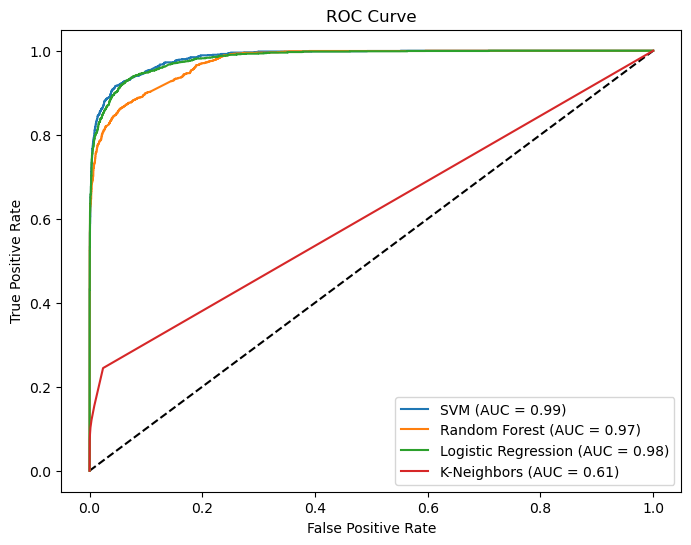

In [92]:
# Graficar la curva ROC para cada modelo
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})")
plt.plot(fpr_knn, tpr_knn, label=f"K-Neighbors (AUC = {roc_auc_knn:.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()